# ConvNet et MobileNet
### Exemple avec DenseNet et MobileNetV2

Les exemples seront traitées sur le dataset du Cifar10 qui est une base de données d'images avec 10 classes dans un premier temps puis en utilisant la base de données d'ImageNet qui possède 1000 classes différentes d'images.

In [ ]:
import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms
from torchvision.models import densenet121, densenet169, densenet201, mobilenet_v2, mobilenet_v3_large, mobilenet_v3_small
import matplotlib.pyplot as plt

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU: Tesla T4


#### Import du dataset Cifar10:

In [ ]:
# Define the transform
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the CIFAR10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create subsets with only 1000 images
train_subset = torch.utils.data.Subset(train_dataset, range(50000))
test_subset = torch.utils.data.Subset(test_dataset,  range(10000))

# Create dataloaders for the subsets
train_dataloader = torch.utils.data.DataLoader(train_subset, batch_size=128, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_subset, batch_size=128, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


#### Définition de fonction de train et test pour la suite :

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 20 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct

## I - DenseNet

### I-1: Une utilisation de DenseNet sans pré-entrainement

In [ ]:
# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.01
BATCH_SIZE = 128
NUM_EPOCHS = 10
batch_size = BATCH_SIZE
# Architecture
NUM_CLASSES = 10

# Other
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
GRAYSCALE = True

In [ ]:
model_dn121 = densenet121(weights=None)
model_dn121.classifier = nn.Linear(model_dn121.classifier.in_features,
                                   NUM_CLASSES,
                                   RANDOM_SEED)  # Assuming 10 classes for CIFAR-10
model_dn121.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_dn121.parameters(), lr=LEARNING_RATE)

In [ ]:
epochs = 30
loss_dn121 = []
accuracy_dn121 = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model_dn121, loss_fn, optimizer)
    test_loop(test_dataloader, model_dn121, loss_fn)
    loss, acc = test_loop(test_dataloader, model_dn121, loss_fn)
    loss_dn121.append(loss)
    accuracy_dn121.append(acc)
print("Done!")

Epoch 1
-------------------------------
loss: 1.404100  [  128/50000]
loss: 1.239376  [ 2688/50000]
loss: 0.786603  [ 5248/50000]
loss: 0.699995  [ 7808/50000]
loss: 0.802761  [10368/50000]
loss: 0.842255  [12928/50000]
loss: 0.993442  [15488/50000]
loss: 0.776535  [18048/50000]
loss: 1.035703  [20608/50000]
loss: 1.434968  [23168/50000]
loss: 1.405491  [25728/50000]
loss: 0.907219  [28288/50000]
loss: 1.061184  [30848/50000]
loss: 0.632494  [33408/50000]
loss: 0.854010  [35968/50000]
loss: 1.271528  [38528/50000]
loss: 1.008261  [41088/50000]
loss: 0.970275  [43648/50000]
loss: 1.180703  [46208/50000]
loss: 1.103167  [48768/50000]
Test Error: 
 Accuracy: 71.2%, Avg loss: 1.576989 

Test Error: 
 Accuracy: 71.2%, Avg loss: 1.576989 

Epoch 2
-------------------------------
loss: 1.010566  [  128/50000]
loss: 0.999382  [ 2688/50000]
loss: 0.832220  [ 5248/50000]
loss: 1.235766  [ 7808/50000]
loss: 1.145713  [10368/50000]
loss: 1.038759  [12928/50000]
loss: 0.939361  [15488/50000]
loss: 

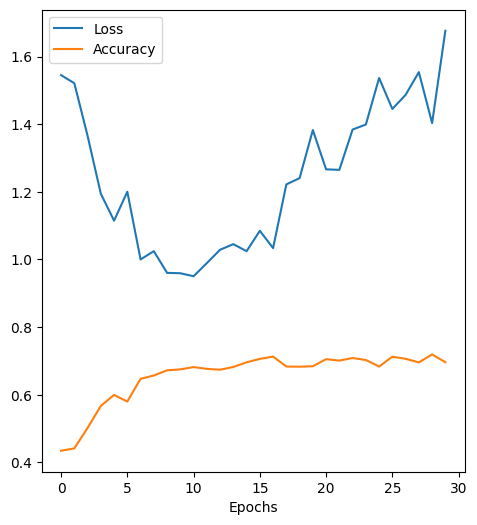

In [ ]:
# Plotting the loss and accuracy for DenseNet models
epochs_range = range(epochs)

plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss_dn121, label='Loss')
plt.xlabel('Epochs')
plt.plot(secondary_y=True, epochs_range, accuracy_dn121, label='Accuracy')
plt.legend()

plt.show()

### I-2 D'autres versions de DenseNet

#### I-2.i. DenseNet169

In [ ]:
model_dn169 = densenet169(weights=None)
model_dn169.classifier = nn.Linear(model_dn169.classifier.in_features, NUM_CLASSES)
model_dn169.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
epochs = 10
loss_dn169 = []
accuracy_dn169 = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model_dn169, loss_fn, optimizer)
    test_loop(test_dataloader, model_dn169, loss_fn)
    loss, acc = test_loop(test_dataloader, model_dn169, loss_fn)
    loss_dn169.append(loss)
    accuracy_dn169.append(acc)
print("Done!")

Epoch 1
-------------------------------
loss: 2.369033  [  128/ 5000]
Test Error: 
 Accuracy: 9.9%, Avg loss: 2.352948 

Test Error: 
 Accuracy: 9.9%, Avg loss: 2.352948 

Epoch 2
-------------------------------
loss: 2.391506  [  128/ 5000]
Test Error: 
 Accuracy: 10.1%, Avg loss: 2.378701 

Test Error: 
 Accuracy: 10.1%, Avg loss: 2.378701 

Epoch 3
-------------------------------
loss: 2.354203  [  128/ 5000]
Test Error: 
 Accuracy: 9.6%, Avg loss: 2.373877 

Test Error: 
 Accuracy: 9.6%, Avg loss: 2.373877 

Epoch 4
-------------------------------
loss: 2.359958  [  128/ 5000]
Test Error: 
 Accuracy: 10.3%, Avg loss: 2.376558 

Test Error: 
 Accuracy: 10.3%, Avg loss: 2.376558 

Epoch 5
-------------------------------
loss: 2.344800  [  128/ 5000]
Test Error: 
 Accuracy: 10.0%, Avg loss: 2.371960 

Test Error: 
 Accuracy: 10.0%, Avg loss: 2.371960 

Epoch 6
-------------------------------
loss: 2.343377  [  128/ 5000]
Test Error: 
 Accuracy: 9.9%, Avg loss: 2.377620 

Test Error: 


####  I-2.ii. DenseNet201

In [ ]:
model_dn201 = densenet201(weights=None)
model_dn201.classifier = nn.Linear(model_dn201.classifier.in_features, NUM_CLASSES)
model_dn201.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
epochs = 10
loss_dn201 = []
accuracy_dn201 = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model_dn201, loss_fn, optimizer)
    test_loop(test_dataloader, model_dn201, loss_fn)
    loss, acc = test_loop(test_dataloader, model_dn201, loss_fn)
    loss_dn201.append(loss)
    accuracy_dn201.append(acc)
print("Done!")

Epoch 1
-------------------------------
loss: 2.343111  [  128/10000]
Test Error: 
 Accuracy: 10.6%, Avg loss: 2.373658 

Test Error: 
 Accuracy: 10.6%, Avg loss: 2.373658 

Epoch 2
-------------------------------
loss: 2.444355  [  128/10000]
Test Error: 
 Accuracy: 10.7%, Avg loss: 2.374320 

Test Error: 
 Accuracy: 10.7%, Avg loss: 2.374320 

Epoch 3
-------------------------------
loss: 2.379615  [  128/10000]
Test Error: 
 Accuracy: 10.9%, Avg loss: 2.383293 

Test Error: 
 Accuracy: 10.9%, Avg loss: 2.383293 

Epoch 4
-------------------------------
loss: 2.386215  [  128/10000]
Test Error: 
 Accuracy: 10.7%, Avg loss: 2.382230 

Test Error: 
 Accuracy: 10.7%, Avg loss: 2.382230 

Epoch 5
-------------------------------
loss: 2.402361  [  128/10000]
Test Error: 
 Accuracy: 10.9%, Avg loss: 2.373441 

Test Error: 
 Accuracy: 10.9%, Avg loss: 2.373441 

Epoch 6
-------------------------------
loss: 2.396736  [  128/10000]
Test Error: 
 Accuracy: 10.8%, Avg loss: 2.383701 

Test Err

### I-3 Comparaison des modèles DenseNet

ValueError: x and y must have same first dimension, but have shapes (30,) and (10,)

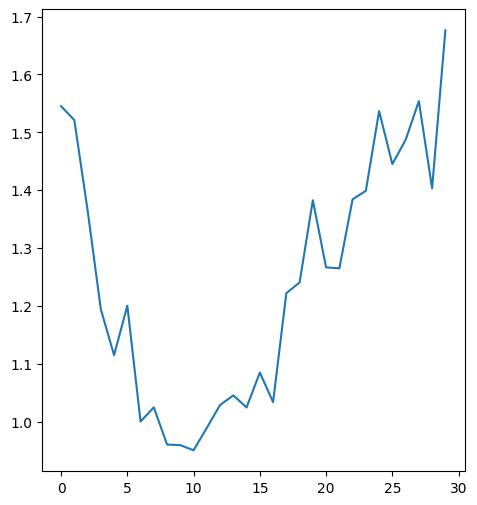

In [ ]:
# Plotting the loss and accuracy for DenseNet models
epochs_range = range(epochs)

plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss_dn121, label='DenseNet121')
plt.plot(epochs_range, loss_dn169, label='DenseNet169')
plt.plot(epochs_range, loss_dn201, label='DenseNet201')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, accuracy_dn121, label='DenseNet121')
plt.plot(epochs_range, accuracy_dn169, label='DenseNet169')
plt.plot(epochs_range, accuracy_dn201, label='DenseNet201')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()

plt.show()

## II - MobileNet

In [ ]:
model_mobilenetv2 = mobilenet_v2(weights=None)
model_mobilenetv2.classifier[1] = nn.Linear(model_mobilenetv2.classifier[1].in_features, NUM_CLASSES)  # Assuming 10 classes for CIFAR-10
model_mobilenetv2.to(DEVICE)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_mobilenetv2.parameters(), lr=LEARNING_RATE)

epochs = 30
loss_mobilenetv2 = []
accuracy_mobilenetv2 = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model_mobilenetv2, loss_fn, optimizer)
    test_loop(test_dataloader, model_mobilenetv2, loss_fn)
    loss, acc = test_loop(test_dataloader, model_mobilenetv2, loss_fn)
    loss_mobilenetv2.append(loss)
    accuracy_mobilenetv2.append(acc)
print("Done!")

Epoch 1
-------------------------------
loss: 2.520238  [  128/20000]
loss: 2.374381  [ 2688/20000]
loss: 2.268046  [ 5248/20000]
loss: 2.394035  [ 7808/20000]
loss: 2.419200  [10368/20000]
loss: 2.838645  [12928/20000]
loss: 2.120433  [15488/20000]
loss: 2.263822  [18048/20000]
Test Error: 
 Accuracy: 15.0%, Avg loss: 2.244212 

Test Error: 
 Accuracy: 15.0%, Avg loss: 2.244212 

Epoch 2
-------------------------------
loss: 2.155680  [  128/20000]
loss: 2.553705  [ 2688/20000]
loss: 2.155154  [ 5248/20000]
loss: 2.052461  [ 7808/20000]
loss: 2.286194  [10368/20000]
loss: 2.239362  [12928/20000]
loss: 2.117088  [15488/20000]
loss: 2.127930  [18048/20000]
Test Error: 
 Accuracy: 19.8%, Avg loss: 2.057538 

Test Error: 
 Accuracy: 19.8%, Avg loss: 2.057538 

Epoch 3
-------------------------------
loss: 2.135686  [  128/20000]
loss: 2.078041  [ 2688/20000]
loss: 2.045174  [ 5248/20000]
loss: 2.001222  [ 7808/20000]
loss: 1.964196  [10368/20000]
loss: 1.891329  [12928/20000]
loss: 2.0308

In [ ]:
model_mobilenetv3_large = mobilenet_v3_large(weights=None)
model_mobilenetv3_large.classifier[3] = nn.Linear(model_mobilenetv3_large.classifier[3].in_features, NUM_CLASSES)  # Assuming 10 classes for CIFAR-10
model_mobilenetv3_large.to(DEVICE)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_mobilenetv3_large.parameters(), lr=LEARNING_RATE)

epochs = 30
loss_mobilenetv3_large = []
accuracy_mobilenetv3_large = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model_mobilenetv3_large, loss_fn, optimizer)
    test_loop(test_dataloader, model_mobilenetv3_large, loss_fn)
    loss, acc = test_loop(test_dataloader, model_mobilenetv3_large, loss_fn)
    loss_mobilenetv3_large.append(loss)
    accuracy_mobilenetv3_large.append(acc)
print("Done!")

Epoch 1
-------------------------------
loss: 2.306855  [  128/20000]
loss: 2.468464  [ 2688/20000]
loss: 2.568797  [ 5248/20000]
loss: 2.311888  [ 7808/20000]
loss: 2.234774  [10368/20000]
loss: 2.051775  [12928/20000]
loss: 2.133830  [15488/20000]
loss: 2.161022  [18048/20000]
Test Error: 
 Accuracy: 10.0%, Avg loss: 2.313934 

Test Error: 
 Accuracy: 10.0%, Avg loss: 2.313934 

Epoch 2
-------------------------------
loss: 1.964265  [  128/20000]
loss: 2.121019  [ 2688/20000]
loss: 2.054111  [ 5248/20000]
loss: 1.983416  [ 7808/20000]
loss: 1.988264  [10368/20000]
loss: 1.955701  [12928/20000]
loss: 1.940334  [15488/20000]
loss: 1.830134  [18048/20000]
Test Error: 
 Accuracy: 11.1%, Avg loss: 2.345420 

Test Error: 
 Accuracy: 11.1%, Avg loss: 2.345420 

Epoch 3
-------------------------------
loss: 2.005698  [  128/20000]
loss: 1.953626  [ 2688/20000]
loss: 1.754048  [ 5248/20000]
loss: 1.826948  [ 7808/20000]
loss: 1.771729  [10368/20000]
loss: 1.710013  [12928/20000]
loss: 1.6612

In [ ]:
model_mobilenetv3_small = mobilenet_v3_small(weights=None)
model_mobilenetv3_small.classifier[3] = nn.Linear(model_mobilenetv3_small.classifier[3].in_features, NUM_CLASSES)  # Assuming 10 classes for CIFAR-10
model_mobilenetv3_small.to(DEVICE)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_mobilenetv3_small.parameters(), lr=LEARNING_RATE)

epochs = 30
loss_mobilenetv3_small = []
accuracy_mobilenetv3_small = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model_mobilenetv3_small, loss_fn, optimizer)
    test_loop(test_dataloader, model_mobilenetv3_small, loss_fn)
    loss, acc = test_loop(test_dataloader, model_mobilenetv3_small, loss_fn)
    loss_mobilenetv3_small.append(loss)
    accuracy_mobilenetv3_small.append(acc)
print("Done!")

Epoch 1
-------------------------------
loss: 2.315316  [  128/20000]
loss: 2.385791  [ 2688/20000]
loss: 2.056760  [ 5248/20000]
loss: 2.075321  [ 7808/20000]
loss: 2.024561  [10368/20000]
loss: 2.085768  [12928/20000]
loss: 2.088564  [15488/20000]
loss: 1.936347  [18048/20000]
Test Error: 
 Accuracy: 10.0%, Avg loss: 2.350428 

Test Error: 
 Accuracy: 10.0%, Avg loss: 2.350428 

Epoch 2
-------------------------------
loss: 1.771949  [  128/20000]
loss: 1.932674  [ 2688/20000]
loss: 1.943200  [ 5248/20000]
loss: 1.927344  [ 7808/20000]
loss: 1.637854  [10368/20000]
loss: 1.815938  [12928/20000]
loss: 1.830177  [15488/20000]
loss: 1.740927  [18048/20000]
Test Error: 
 Accuracy: 21.7%, Avg loss: 2.180353 

Test Error: 
 Accuracy: 21.7%, Avg loss: 2.180353 

Epoch 3
-------------------------------
loss: 1.732448  [  128/20000]
loss: 1.758041  [ 2688/20000]
loss: 1.870090  [ 5248/20000]
loss: 1.943123  [ 7808/20000]
loss: 1.845307  [10368/20000]
loss: 1.681391  [12928/20000]
loss: 1.9077

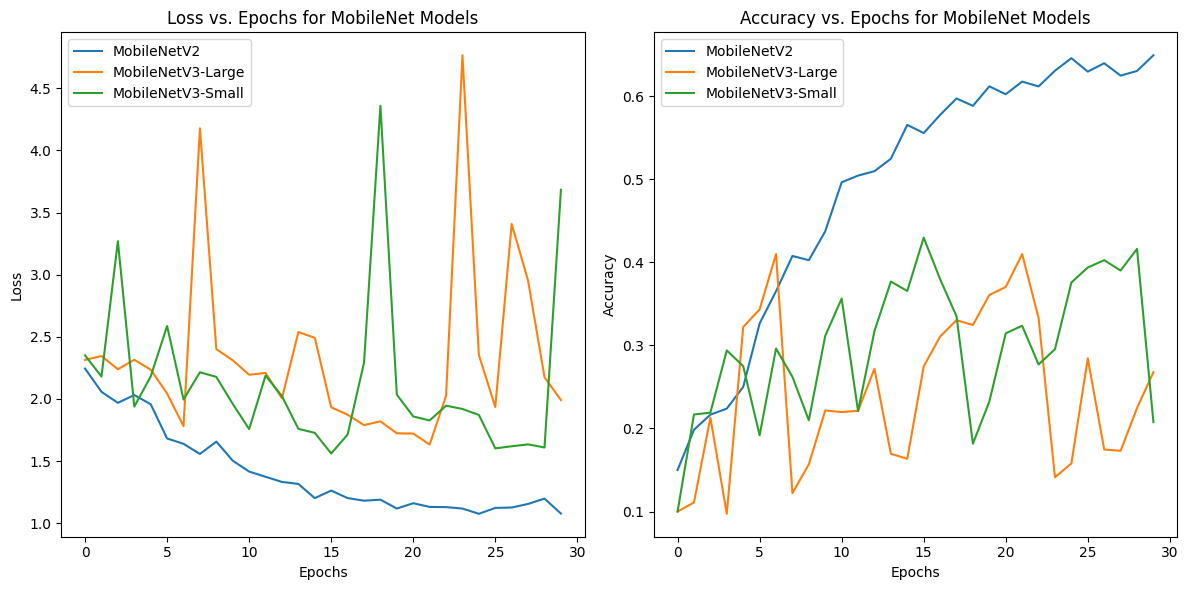

In [ ]:
epochs_range = range(epochs)

plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss_mobilenetv2, label='MobileNetV2')
plt.plot(epochs_range, loss_mobilenetv3_large, label='MobileNetV3-Large')
plt.plot(epochs_range, loss_mobilenetv3_small, label='MobileNetV3-Small')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs for MobileNet Models')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, accuracy_mobilenetv2, label='MobileNetV2')
plt.plot(epochs_range, accuracy_mobilenetv3_large, label='MobileNetV3-Large')
plt.plot(epochs_range, accuracy_mobilenetv3_small, label='MobileNetV3-Small')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs for MobileNet Models')
plt.legend()

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()